### Import necessary modules and libraries

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pprint
from scipy import stats
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn import neighbors


from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

### Define ancillary functions

#### Set a wavelength range for a dataframe containing reflectance data

In [2]:
# Define a fuction to select a sub-range of wavelengths for each dataframe to be used in the calculation
# Each dataframe needs to have the same WL range of the others
def df_bounds(wl_1, wl_2, df):
    
    
    b_df = df[(df.WL_nm >= wl_1) & (df.WL_nm <= wl_2)]
    
    # Reset the index column of the datframe
    b_df = b_df.reset_index()
    
    # Delete the first index column (to avoid indicization problems)
    b_df.pop('index')
    return b_df

#### Slope calculation

In [3]:
def slope(wl_1, wl_2, df):
    
    n_col = df.shape[1]
    
    x1 = wl_1
    x2 = wl_2
    
    
    sl = []
    
    for i in range(1, n_col):

    
        refl_i = df[(df.WL_nm == wl_1)].iloc[0, i]
        refl_f = df[(df.WL_nm == wl_2)].iloc[0, i]
        
        slope = (refl_f - refl_i) / (wl_2 - wl_1)
        sl.append(slope)
        
    return (sl)

#### Average reflectance

In [4]:
# The function calculates the average value of reflectance between two given wavelengths

def av_refl(wl_1, wl_2, df):
    
    
    b_df = df[(df.WL_nm >= wl_1) & (df.WL_nm <= wl_2)]
    averRefl = df.mean(axis=0)
    #averRefl = averRefl.iloc[: , 1:]
    return (averRefl)

### Import DB_info and DB_spectra

#### Import information database

In [6]:
# To red the xlsx files put them in the same folder of the present notebook otherwise define a path and pass it to
# read_excel function

df_glasses = pd.read_excel('ds02.xlsx')
df_glasses

,sptr_name,GS_um,std_dev_GS,SiO2,TiO2,Al2O3,Cr2O3,FeO,MnO,MgO,...,R415_R750,Fe3_Fe_tot,T_closure,Glass_vol%,Pig_vol%,Aug_vol%,Plag_vol%,Mag_vol%,groundmass,Oxdtn_durt_h
0,St18g_250-224,237.0,18.384776,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.419986,0.508,1350,100,0,0,0,0,0,0
1,St18g_224-200,212.0,16.970563,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.422041,0.508,1350,100,0,0,0,0,0,0
2,St18g_200-180,190.0,14.142136,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.435146,0.508,1350,100,0,0,0,0,0,0
3,St18g_180-150,165.0,21.213203,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.483101,0.508,1350,100,0,0,0,0,0,0
4,St18g_150-125,137.5,17.677670,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.502045,0.508,1350,100,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,P_100_125,112.5,17.677670,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.811153,0.137,ND,ND,ND,ND,ND,ND,ND,ND
223,P_125_150,137.5,17.677670,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.878922,0.137,ND,ND,ND,ND,ND,ND,ND,ND
224,P_150_180,165.0,21.213203,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.839225,0.137,ND,ND,ND,ND,ND,ND,ND,ND
225,P_180_200,190.0,14.142136,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.845903,0.137,ND,ND,ND,ND,ND,ND,ND,ND


#### Import spectra database

In [7]:

filename = 'ds03.xlsx'

df_carli = pd.read_excel(filename, sheet_name='Carli_2016')
df_cannon = pd.read_excel(filename, sheet_name='Cannon_2017')
df_pisello = pd.read_excel(filename, sheet_name='Pisello_2022')
df_stockW = pd.read_excel(filename, sheet_name='Stockstill_Well')
df_minitti = pd.read_excel(filename, sheet_name='Minitti_2002')
df_moroz = pd.read_excel(filename, sheet_name='Moroz_2009')
df_farrand = pd.read_excel(filename, sheet_name='Farrand_2016')
df_bruschini = pd.read_excel(filename, sheet_name='Bruschini_2022')

#### Create sub-set of the dataframes

In [8]:
df_carli_bounds   = df_bounds(350, 2400, df_carli)
df_cannon_bounds  = df_bounds(350, 2400, df_cannon).drop(columns="WL_nm")
df_pisello_bounds = df_bounds(350, 2400, df_pisello).drop(columns="WL_nm")
df_stockW_bounds  = df_bounds(350, 2400, df_stockW).drop(columns="WL_nm")
df_minitti_bounds = df_bounds(350, 2400, df_minitti).drop(columns="WL_nm")
df_moroz_bounds   = df_bounds(350, 2400, df_moroz).drop(columns="WL_nm")
df_farr_bounds    = df_bounds(350, 2400, df_farrand).drop(columns="WL_nm")
df_brus_bounds    = df_bounds(350, 2400, df_bruschini).drop(columns="WL_nm")

#### Concatenates the dataframes

In [9]:
# Concatenate the df for each dataset into a new dataframe called df

frames = [df_carli_bounds, df_cannon_bounds, df_pisello_bounds, df_stockW_bounds, df_minitti_bounds, df_moroz_bounds, df_farr_bounds, df_brus_bounds]



df = pd.concat(
    frames,
    axis=1,
    verify_integrity=True)

In [10]:
df.shape

(2051, 228)

In [11]:
df

,WL_nm,St18g_250_224,St18g_224_200,St18g_200_180,St18g_180_150,St18g_150_125,St18g_125_100,St18g_100_75,St18g_75_50,St18g_50_20,...,I_180_200,I_200_250,P_0_25,P_25_63,P_63_100,P_100_125,P_125_150,P_150_180,P_180_200,P_200_250
0,350.0,0.04974,0.05342,0.05188,0.08674,0.08861,0.09632,0.08174,0.11897,0.19065,...,0.022359,0.020733,0.127061,0.061973,0.048681,0.039991,0.039777,0.034029,0.030587,0.019380
1,351.0,0.03803,0.04856,0.05078,0.07965,0.09087,0.08995,0.09041,0.13881,0.19898,...,0.024925,0.027243,0.122246,0.059550,0.046916,0.052212,0.043904,0.038405,0.030202,0.022259
2,352.0,0.04358,0.05476,0.05709,0.07847,0.08586,0.09361,0.08863,0.13859,0.19295,...,0.025068,0.029036,0.121014,0.058863,0.048724,0.053893,0.044215,0.036622,0.031127,0.020726
3,353.0,0.05830,0.06376,0.06522,0.07641,0.07672,0.09686,0.08385,0.12803,0.18429,...,0.024401,0.027901,0.124203,0.060250,0.051846,0.051356,0.043449,0.036892,0.036171,0.024217
4,354.0,0.06413,0.06314,0.06852,0.06541,0.07093,0.08713,0.08967,0.12716,0.18742,...,0.025142,0.027113,0.129744,0.062833,0.053990,0.050210,0.044114,0.041896,0.043464,0.033629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2396.0,0.43601,0.44121,0.46287,0.50086,0.52976,0.55447,0.59889,0.64215,0.69527,...,0.148705,0.130023,0.328338,0.175380,0.114331,0.087868,0.067547,0.063544,0.049770,0.045299
2047,2397.0,0.43754,0.44213,0.46217,0.50204,0.53110,0.55501,0.60049,0.64075,0.69713,...,0.148884,0.131437,0.328977,0.175798,0.116085,0.087283,0.067217,0.062133,0.052267,0.046438
2048,2398.0,0.43819,0.44368,0.46249,0.49999,0.52929,0.55643,0.59762,0.63981,0.69748,...,0.149652,0.131894,0.327901,0.175363,0.117416,0.086345,0.066267,0.061986,0.054199,0.048118
2049,2399.0,0.43662,0.44460,0.46132,0.50005,0.53136,0.55691,0.59360,0.63741,0.69487,...,0.149659,0.131706,0.324648,0.173452,0.118385,0.086181,0.065322,0.062435,0.055361,0.049676


#### Slope(s) calculation

In [12]:
# Calculate a few spectral slopes for later use

sl_400_600 = slope(400, 600, df)
sl_600_800 = slope(600, 800, df)
sl_900_1200 = slope(900, 1200, df)
sl_500_1000 = slope(500, 1000, df)

### Spectral binning

In [13]:
## Bin reflectance data using the mean as statistic

# Define the number of bins
bins = 30

# Extract from the dataframe the column with the wavelengths --> x_wl is now  a series
x_wl = df.iloc[:, 0]

# Create an empty list to be populated in the following for loop
bin_sp = []

# Loop troughth the dataframe columns (spectra), bin them using the mean and store the results in the "bin_sp" variable
for i in range(1, df.shape[1]):
    df_n = df.iloc[:, i]
    bin_means, bin_edges, binnumber = stats.binned_statistic(x_wl, df_n, bins=bins)
    bin_sp.append(bin_means)

In [14]:
# Create an empty list (names of the binned spectra columns) to be populated in the following for loop
binname = []

# Loop troughth the number of bins to create a name for each bin. Allocate the bin names in the variable "binname"
for j in range(1, bins+1):

    b_nms = 'bin_' + str(j)
    binname.append(b_nms)
    
    
# Create a new dataframe with the binned spectra    
df_bnsp = pd.DataFrame(bin_sp)

# Assign a name to each column
df_bnsp.columns = binname

# Show the results
df_bnsp

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_21,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30
0,0.077392,0.181156,0.254397,0.294212,0.308461,0.309633,0.296934,0.275897,0.258314,0.247927,...,0.359956,0.363469,0.368812,0.376263,0.385261,0.394131,0.403942,0.412727,0.423010,0.430233
1,0.080453,0.192049,0.268335,0.308962,0.323549,0.325240,0.313230,0.292661,0.274994,0.264804,...,0.380118,0.383834,0.389283,0.396401,0.405483,0.414284,0.423915,0.432272,0.441771,0.446087
2,0.087020,0.204660,0.283102,0.324660,0.339468,0.340978,0.328348,0.307161,0.289132,0.278584,...,0.394922,0.398570,0.403275,0.410694,0.420682,0.429512,0.439266,0.447887,0.455971,0.461008
3,0.114232,0.246261,0.328280,0.370548,0.385406,0.385929,0.371913,0.350191,0.332049,0.320869,...,0.433964,0.437891,0.442186,0.448707,0.456969,0.465314,0.474694,0.482663,0.490853,0.496235
4,0.127694,0.270460,0.354233,0.396654,0.411743,0.413164,0.400199,0.379018,0.361239,0.350574,...,0.465230,0.469198,0.473824,0.480044,0.489015,0.497621,0.507302,0.515820,0.524545,0.529117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.053030,0.056033,0.057005,0.059712,0.063743,0.067272,0.068177,0.066020,0.064113,0.064582,...,0.073881,0.074033,0.072937,0.073786,0.076198,0.077790,0.079681,0.081081,0.084029,0.086569
223,0.047665,0.049607,0.049167,0.050286,0.053026,0.055723,0.056283,0.054337,0.052640,0.052957,...,0.059761,0.059684,0.058641,0.059088,0.060839,0.062083,0.063530,0.063702,0.065852,0.068164
224,0.043713,0.047220,0.047734,0.049484,0.052113,0.054778,0.055561,0.053787,0.052227,0.052362,...,0.057160,0.057060,0.056241,0.056258,0.057759,0.058424,0.059505,0.059939,0.062437,0.063145
225,0.041476,0.045323,0.046126,0.047560,0.049514,0.051875,0.052226,0.050013,0.048352,0.048553,...,0.052424,0.052156,0.050737,0.050710,0.051469,0.052269,0.052830,0.052654,0.054505,0.054325


### Merge binned spectra to the DB_info

In [15]:
# Add the bins of each spectrum to the dataframe df_glasses

frames_b = [df_glasses, df_bnsp]
df_glasses = pd.concat(
    frames_b,
    axis=1,
    verify_integrity=True)

df_glasses

,sptr_name,GS_um,std_dev_GS,SiO2,TiO2,Al2O3,Cr2O3,FeO,MnO,MgO,...,bin_21,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30
0,St18g_250-224,237.0,18.384776,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.359956,0.363469,0.368812,0.376263,0.385261,0.394131,0.403942,0.412727,0.423010,0.430233
1,St18g_224-200,212.0,16.970563,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.380118,0.383834,0.389283,0.396401,0.405483,0.414284,0.423915,0.432272,0.441771,0.446087
2,St18g_200-180,190.0,14.142136,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.394922,0.398570,0.403275,0.410694,0.420682,0.429512,0.439266,0.447887,0.455971,0.461008
3,St18g_180-150,165.0,21.213203,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.433964,0.437891,0.442186,0.448707,0.456969,0.465314,0.474694,0.482663,0.490853,0.496235
4,St18g_150-125,137.5,17.677670,48.18,0.08,29.36,0.00,1.601662,0.03,1.92,...,0.465230,0.469198,0.473824,0.480044,0.489015,0.497621,0.507302,0.515820,0.524545,0.529117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,P_100_125,112.5,17.677670,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.073881,0.074033,0.072937,0.073786,0.076198,0.077790,0.079681,0.081081,0.084029,0.086569
223,P_125_150,137.5,17.677670,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.059761,0.059684,0.058641,0.059088,0.060839,0.062083,0.063530,0.063702,0.065852,0.068164
224,P_150_180,165.0,21.213203,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.057160,0.057060,0.056241,0.056258,0.057759,0.058424,0.059505,0.059939,0.062437,0.063145
225,P_180_200,190.0,14.142136,60.78,0.87,16.90,0.05,8.000000,0.07,4.00,...,0.052424,0.052156,0.050737,0.050710,0.051469,0.052269,0.052830,0.052654,0.054505,0.054325


In [16]:
# Check the names of the df_glasses columns

df_glasses.columns.values

array(['sptr_name', 'GS_um', 'std_dev_GS', 'SiO2', 'TiO2', 'Al2O3',
       'Cr2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'LOI',
       'FeO+TiO2', 'sl_400_2200', 'avrg_refl', 'R415_R750', 'Fe3_Fe_tot',
       'T_closure', 'Glass_vol%', 'Pig_vol%', 'Aug_vol%', 'Plag_vol%',
       'Mag_vol%', 'groundmass', 'Oxdtn_durt_h', 'bin_1', 'bin_2',
       'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7', 'bin_8', 'bin_9',
       'bin_10', 'bin_11', 'bin_12', 'bin_13', 'bin_14', 'bin_15',
       'bin_16', 'bin_17', 'bin_18', 'bin_19', 'bin_20', 'bin_21',
       'bin_22', 'bin_23', 'bin_24', 'bin_25', 'bin_26', 'bin_27',
       'bin_28', 'bin_29', 'bin_30'], dtype=object)

In [17]:
# Check the dimensions of the df_glasses dataframe
df_glasses.shape

(227, 58)

In [18]:
# Get detailed information of the glasses dataframe
df_glasses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sptr_name     227 non-null    object 
 1   GS_um         227 non-null    float64
 2   std_dev_GS    227 non-null    float64
 3   SiO2          227 non-null    float64
 4   TiO2          227 non-null    float64
 5   Al2O3         227 non-null    float64
 6   Cr2O3         227 non-null    float64
 7   FeO           227 non-null    float64
 8   MnO           227 non-null    float64
 9   MgO           227 non-null    float64
 10  CaO           227 non-null    float64
 11  Na2O          227 non-null    float64
 12  K2O           227 non-null    float64
 13  P2O5          227 non-null    float64
 14  LOI           227 non-null    float64
 15  FeO+TiO2      227 non-null    float64
 16  sl_400_2200   227 non-null    float64
 17  avrg_refl     227 non-null    float64
 18  R415_R750     227 non-null    

### Clean the dataset and prepare it for the $Fe^{3+} / Fe_{TOT}$ prediction

#### Drop the unnecessary columns

In [19]:
# Some features were considered not useful for Fe3+/Fe_tot prediction and hence they were removed from the df
df_g2 = df_glasses.drop(df_glasses.iloc[:, 20:28],axis = 1)

# Get information of the new dataframe
df_g2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 50 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sptr_name    227 non-null    object 
 1   GS_um        227 non-null    float64
 2   std_dev_GS   227 non-null    float64
 3   SiO2         227 non-null    float64
 4   TiO2         227 non-null    float64
 5   Al2O3        227 non-null    float64
 6   Cr2O3        227 non-null    float64
 7   FeO          227 non-null    float64
 8   MnO          227 non-null    float64
 9   MgO          227 non-null    float64
 10  CaO          227 non-null    float64
 11  Na2O         227 non-null    float64
 12  K2O          227 non-null    float64
 13  P2O5         227 non-null    float64
 14  LOI          227 non-null    float64
 15  FeO+TiO2     227 non-null    float64
 16  sl_400_2200  227 non-null    float64
 17  avrg_refl    227 non-null    float64
 18  R415_R750    227 non-null    float64
 19  Fe3_Fe_t

#### Add new features (columns)

In [20]:
# Calculate new features and add them to the df

df_g2['SiAl'] = df_g2['SiO2'] + df_g2['Al2O3']
df_g2['CaAl'] = df_g2['CaO'] + df_g2['Al2O3']

df_g2.insert(52, 'Sl_500_1000', sl_500_1000)

df_g2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sptr_name    227 non-null    object 
 1   GS_um        227 non-null    float64
 2   std_dev_GS   227 non-null    float64
 3   SiO2         227 non-null    float64
 4   TiO2         227 non-null    float64
 5   Al2O3        227 non-null    float64
 6   Cr2O3        227 non-null    float64
 7   FeO          227 non-null    float64
 8   MnO          227 non-null    float64
 9   MgO          227 non-null    float64
 10  CaO          227 non-null    float64
 11  Na2O         227 non-null    float64
 12  K2O          227 non-null    float64
 13  P2O5         227 non-null    float64
 14  LOI          227 non-null    float64
 15  FeO+TiO2     227 non-null    float64
 16  sl_400_2200  227 non-null    float64
 17  avrg_refl    227 non-null    float64
 18  R415_R750    227 non-null    float64
 19  Fe3_Fe_t

#### Drop the rows with ND values in the "Fe3_Fe_tot" column

In [21]:
# Retrieve the indices of the rows without the Fe3+_Fetot ratio (Fe3_Fe_tot = ND)
ND_indcs = df_g2.index[df_g2['Fe3_Fe_tot'] == 'ND'].tolist()

# Store the retrieved data into a new dataframe for later use
no_Fe_ratio = df_g2[df_g2['Fe3_Fe_tot'] == 'ND']

# Drop the lines with the 'ND' values in the 'Fe3_Fe_tot' column of the original dataframe
df_g2.drop(ND_indcs, inplace=True)
df_g2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 226
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sptr_name    199 non-null    object 
 1   GS_um        199 non-null    float64
 2   std_dev_GS   199 non-null    float64
 3   SiO2         199 non-null    float64
 4   TiO2         199 non-null    float64
 5   Al2O3        199 non-null    float64
 6   Cr2O3        199 non-null    float64
 7   FeO          199 non-null    float64
 8   MnO          199 non-null    float64
 9   MgO          199 non-null    float64
 10  CaO          199 non-null    float64
 11  Na2O         199 non-null    float64
 12  K2O          199 non-null    float64
 13  P2O5         199 non-null    float64
 14  LOI          199 non-null    float64
 15  FeO+TiO2     199 non-null    float64
 16  sl_400_2200  199 non-null    float64
 17  avrg_refl    199 non-null    float64
 18  R415_R750    199 non-null    float64
 19  Fe3_Fe_t

In [22]:
# Convert the 'Fe3_Fe_tot' column into float
df_g2['Fe3_Fe_tot'] = df_g2['Fe3_Fe_tot'].astype(float)
df_g2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 226
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sptr_name    199 non-null    object 
 1   GS_um        199 non-null    float64
 2   std_dev_GS   199 non-null    float64
 3   SiO2         199 non-null    float64
 4   TiO2         199 non-null    float64
 5   Al2O3        199 non-null    float64
 6   Cr2O3        199 non-null    float64
 7   FeO          199 non-null    float64
 8   MnO          199 non-null    float64
 9   MgO          199 non-null    float64
 10  CaO          199 non-null    float64
 11  Na2O         199 non-null    float64
 12  K2O          199 non-null    float64
 13  P2O5         199 non-null    float64
 14  LOI          199 non-null    float64
 15  FeO+TiO2     199 non-null    float64
 16  sl_400_2200  199 non-null    float64
 17  avrg_refl    199 non-null    float64
 18  R415_R750    199 non-null    float64
 19  Fe3_Fe_t

In [23]:
# Remove the column with spectra names from the dataframe
sp_names = df_g2.pop('sptr_name')

### Exploratory Data Analysis (EDA)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<Figure size 432x288 with 0 Axes>

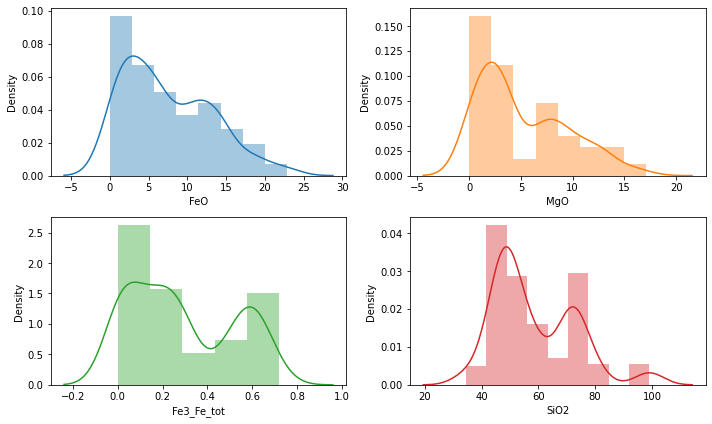

<Figure size 432x288 with 0 Axes>

In [24]:
def multiplot(data, features, plottype, nrows, ncols, figsize, y=None, colorize=False):
    n=0
    plt.figure(1)
    fig, axes=plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors=sns.color_palette(n_colors=(nrows*ncols))
    else:
        colors=[None]*(nrows*ncols)
    
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype=='regplot':
                if y==None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data=data, x=features[n],y=y,ax=axes[row,col],color=colors[n])
                correlation=np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title('Correlation {:.2f}'.format(correlation))
                
            elif plottype=='distplot':
                sns.distplot(a=data[features[n]],ax=axes[row,col],color=colors[n])
            
    
            n+=1
        
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()


feats = ["FeO","MgO","Fe3_Fe_tot","SiO2"]

# multiplot(data = df_g2,features = feats,plottype = "distplot",nrows = 2, ncols = 2,
#           figsize = (10,6),y = "Bin_15", colorize = True);

multiplot(data = df_g2,features = feats,plottype = "distplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = "Bin_1", colorize = True);

These are hystograms to show chemical information about the samples in the DB. Solid lines are PDF (Partial Density Function)

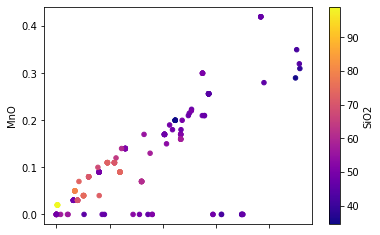

In [25]:
# Scatter plots FeO vs MnO - shades represent SiO2 content of the samples
ax2 = df_g2.plot.scatter(x='FeO',
                       y='MnO',
                       c='SiO2',
                       colormap='plasma')

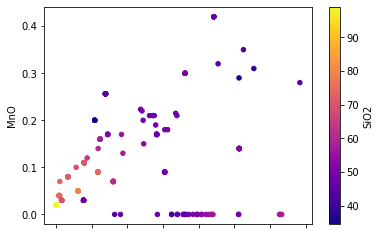

In [26]:
# Scatter plots MgO vs MnO - shades represent SiO2 content of the samples
ax3 = df_g2.plot.scatter(x='MgO',
                       y='MnO',
                       c='SiO2',
                       colormap='plasma')

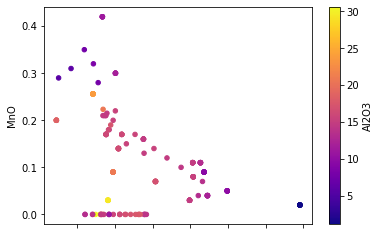

In [27]:
# Scatter plots SiO2 vs MnO - shades represent Al2O3 content of the samples
ax3 = df_g2.plot.scatter(x='SiO2',
                       y='MnO',
                       c='Al2O3',
                       colormap='plasma')

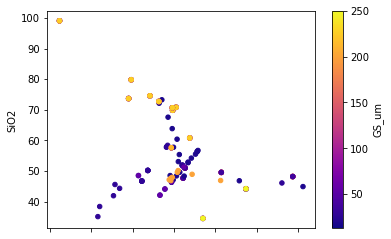

In [28]:
# Scatter plots Al2O3 vs SiO2 - shades represent grainsize
ax4 = df_g2.plot.scatter(x='Al2O3',
                       y='SiO2',
                       c='GS_um',
                       colormap='plasma')

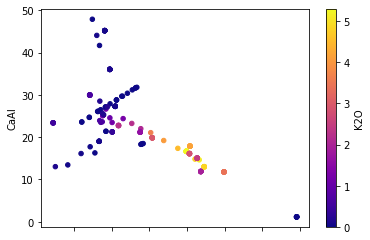

In [29]:
# Scatter plots SiO2 vs CaO+Al2O3 - shades represent K2O content of the samples
ax5 = df_g2.plot.scatter(x='SiO2',
                       y='CaAl',
                       c='K2O',
                       colormap='plasma')

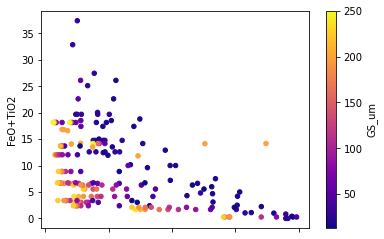

In [30]:
ax6 = df_g2.plot.scatter(x='avrg_refl',
                       y='FeO+TiO2',
                       c='GS_um',
                       colormap='plasma')

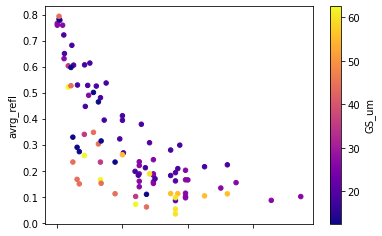

In [31]:
# Select only the data with GS < 63um and plot the results FeO+TiO2 vs avrg_refl vs slope

df_fine = df_g2[(df_g2.GS_um <= 65)]
ax8 = df_fine.plot.scatter(x='FeO+TiO2',
                       y='avrg_refl',
                       c='GS_um',
                       colormap='plasma')


In [37]:
# This command outputs an xlsx file with all the data of the DB
df_g2.to_excel("output.xlsx") 

### Build the ML models

#### Define the feature matrix and the label vector

In [32]:
# 'Labels' vector
y = df_g2.pop('Fe3_Fe_tot')

# 'Features' matrix
X = df_g2.to_numpy()

# 'Labels' vector
y = y.to_numpy()

#### Test and train splitting

In [33]:
# Test and train splitting
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=16)

In [34]:
y_test

array([0.5       , 0.508     , 0.071     , 0.        , 0.26869454,
       0.047     , 0.01      , 0.508     , 0.6       , 0.6       ,
       0.01      , 0.65      , 0.        , 0.208     , 0.        ,
       0.01      , 0.01      , 0.305     , 0.        , 0.31      ,
       0.01      , 0.071     , 0.20701488, 0.52419651, 0.21      ,
       0.        , 0.135     , 0.52      , 0.208     , 0.24      ,
       0.137     , 0.613     , 0.01      , 0.65      , 0.25      ,
       0.5       , 0.595     , 0.281     , 0.5       , 0.25      ])

#### Features scaling

In [35]:
scaler  = MinMaxScaler()

X_tr_sc = scaler.fit_transform(X_train)
X_tr    = pd.DataFrame(X_tr_sc)

X_ts_sc = scaler.fit_transform(X_test)
X_ts    = pd.DataFrame(X_ts_sc)

#### Random forest

In [36]:
# Define the values to be put in the grid
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 50)]
max_features = [30]
max_depth = [int(x) for x in np.linspace(5, 30, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [6, 8, 10, 12]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
# Define the model to work with
rf = RandomForestRegressor()

# The hyperparameters are optimized through a randomized search (less computationally intensive)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 4, verbose=2, random_state=16, n_jobs = -1)

# Fit the model
rf_random.fit(X_tr_sc, y_train)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 10, 11, 12,
                                                      14, 15, 16, 18, 19, 20,
                                                      22, 23, 24, 26, 27, 28,
                                                      30, None],
                                        'max_features': [30],
                                        'min_samples_leaf': [6, 8, 10, 12],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [1, 5, 9, 13, 17, 21,
                                                         25, 29, 33, 37, 41, 45,
                                                         49, 53, 57, 61, 65, 70,
                                                         74, 78, 82, 86, 90,

In [38]:
# Output the best parameters fit by the model
rf_random.best_params_

{'n_estimators': 41,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 30,
 'max_depth': 10,
 'bootstrap': True}

In [39]:
# Feed the model with the best-fit parameters and fir the training set
selected_rf=RandomForestRegressor(n_estimators=41, min_samples_split=5, min_samples_leaf=6, max_features = 30, max_depth=10)
selected_rf.fit(X_tr_sc,y_train)

# Predict the values according to the optimed model and calculate the metrics (MAE, MSE, RMSE)
rf_preds=selected_rf.predict(X_ts_sc)
mean_absolute_error(y_test,rf_preds),mean_squared_error(y_test,rf_preds),np.sqrt(mean_squared_error(y_test,rf_preds)),(y_test,rf_preds)

(0.08688140299168279,
 0.012919029140245869,
 0.11366190716438762,
 (array([0.5       , 0.508     , 0.071     , 0.        , 0.26869454,
         0.047     , 0.01      , 0.508     , 0.6       , 0.6       ,
         0.01      , 0.65      , 0.        , 0.208     , 0.        ,
         0.01      , 0.01      , 0.305     , 0.        , 0.31      ,
         0.01      , 0.071     , 0.20701488, 0.52419651, 0.21      ,
         0.        , 0.135     , 0.52      , 0.208     , 0.24      ,
         0.137     , 0.613     , 0.01      , 0.65      , 0.25      ,
         0.5       , 0.595     , 0.281     , 0.5       , 0.25      ]),
  array([0.27477623, 0.50124961, 0.13731622, 0.12581779, 0.29179595,
         0.07072542, 0.03686382, 0.49500423, 0.53716905, 0.54866522,
         0.043599  , 0.47033805, 0.16917358, 0.22994808, 0.13498669,
         0.22301898, 0.03287789, 0.35113939, 0.05221655, 0.23608855,
         0.08925342, 0.13448023, 0.3634781 , 0.3845373 , 0.38711113,
         0.20304903, 0.14467773, 0

In [40]:
# Print the test set
y_test

array([0.5       , 0.508     , 0.071     , 0.        , 0.26869454,
       0.047     , 0.01      , 0.508     , 0.6       , 0.6       ,
       0.01      , 0.65      , 0.        , 0.208     , 0.        ,
       0.01      , 0.01      , 0.305     , 0.        , 0.31      ,
       0.01      , 0.071     , 0.20701488, 0.52419651, 0.21      ,
       0.        , 0.135     , 0.52      , 0.208     , 0.24      ,
       0.137     , 0.613     , 0.01      , 0.65      , 0.25      ,
       0.5       , 0.595     , 0.281     , 0.5       , 0.25      ])

In [41]:
# Print the predictions
rf_preds

array([0.27477623, 0.50124961, 0.13731622, 0.12581779, 0.29179595,
       0.07072542, 0.03686382, 0.49500423, 0.53716905, 0.54866522,
       0.043599  , 0.47033805, 0.16917358, 0.22994808, 0.13498669,
       0.22301898, 0.03287789, 0.35113939, 0.05221655, 0.23608855,
       0.08925342, 0.13448023, 0.3634781 , 0.3845373 , 0.38711113,
       0.20304903, 0.14467773, 0.46445887, 0.22994808, 0.38379943,
       0.2443929 , 0.56090166, 0.04842227, 0.33582688, 0.2363282 ,
       0.37958066, 0.59931137, 0.35078065, 0.37794519, 0.239545  ])

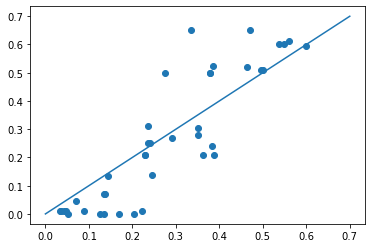

In [42]:
# Creata a scatter plot of observed vs predicted values
plt.scatter(rf_preds, y_test)

x_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
y_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]

plt.plot(x_l, y_l)

In [43]:
# Create a df with the y-test set ('Actual') and the predictions ('Predicted')
df_preds=pd.DataFrame({'Actual':y_test, 'Predicted':rf_preds})
df_preds

,Actual,Predicted
0,0.500000,0.274776
1,0.508000,0.501250
2,0.071000,0.137316
3,0.000000,0.125818
4,0.268695,0.291796
5,0.047000,0.070725
6,0.010000,0.036864
7,0.508000,0.495004
8,0.600000,0.537169
9,0.600000,0.548665


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


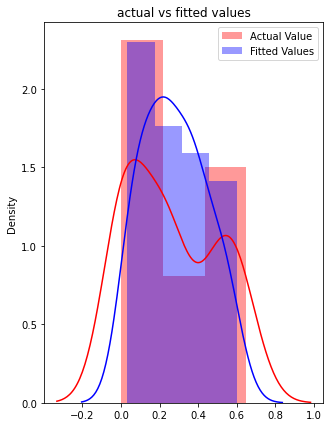

In [44]:
# Display the results with an histogram and superimposed PDF 
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=True, color="r", label="Actual Value")
sns.distplot(rf_preds, hist=True, color="b", label="Fitted Values" , ax=ax)
ax.legend()


plt.title('actual vs fitted values')


plt.show()
plt.close()

In [45]:
# Display the R2 score
r2_score(y_test, rf_preds)

0.7517911623192804

#### Gradient boosting

In [46]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

In [47]:
from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [48]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0037


In [49]:
mae = mean_absolute_error(y_test,reg.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 0.0356


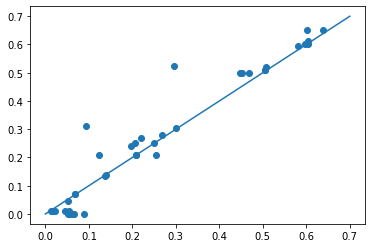

In [50]:
GB_preds = reg.predict(X_test)

plt.scatter(GB_preds, y_test)

x_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
y_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
plt.plot(x_l, y_l)

In [51]:
df_GBpreds=pd.DataFrame({'Actual':y_test, 'Predicted':GB_preds})
df_GBpreds

,Actual,Predicted
0,0.500000,0.447299
1,0.508000,0.504700
2,0.071000,0.067301
3,0.000000,0.063173
4,0.268695,0.219387
5,0.047000,0.050869
6,0.010000,0.044001
7,0.508000,0.505281
8,0.600000,0.596166
9,0.600000,0.603338


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


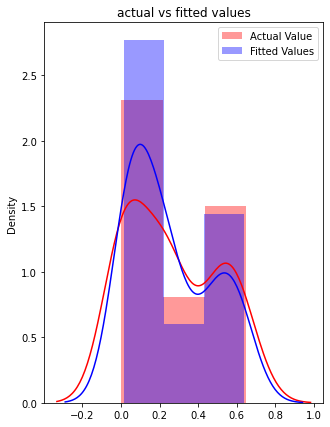

In [52]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=True, color="r", label="Actual Value")
sns.distplot(GB_preds, hist=True, color="b", label="Fitted Values" , ax=ax)
ax.legend()


plt.title('actual vs fitted values')


plt.show()
plt.close()

In [53]:
selected_GB=RandomForestRegressor(n_estimators=191, min_samples_split=5, min_samples_leaf=6, max_features = 20, max_depth=23)
selected_rf.fit(X_tr_sc,y_train)
rf_preds=selected_rf.predict(X_ts_sc)
mean_absolute_error(y_test,rf_preds),mean_squared_error(y_test,rf_preds),np.sqrt(mean_squared_error(y_test,rf_preds)),r2_score(y_test,rf_preds)

(0.09201826382727257,
 0.013486203663612173,
 0.11613011523120165,
 0.7408942344094029)

#### Support vector regressor

In [56]:
#score_fnc=mean_squared_error

score_fnc=mean_absolute_error

param_grid = [
                #{'kernel':['linear'],
                # 'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},

                {'kernel':['poly'],
                 'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                 'degree':[2,3,5,7,9,10,11,12],
                 'gamma' : [1e-1, 1, 5, 10],
                },

                {'kernel':['rbf'],
                 'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                 'gamma' : [1e-1, 1, 10, 100, 1000]}
            
            ]
cv=KFold(n_splits=5,shuffle=True,random_state=0)
svm=SVR()

model_selection=GridSearchCV(svm,param_grid=param_grid,scoring=make_scorer(score_fnc),cv=cv)


model_selection.fit(X_tr_sc,y_train)
model_selection.best_estimator_

SVR(C=0.001, degree=12, gamma=5, kernel='poly')

In [113]:
score_fnc=mean_squared_error
param_grid = [
                #{'kernel':['linear'],
                # 'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},

                {'kernel':['poly'],
                 'C':[0.01,0.05,0.1,0.5,1,1.5,2,5,10,15,20,30,50,100],
                 'degree':[2,3,5,7,9,10,11,12],
                 'gamma' : [1e-1, 1, 5, 10],
                },

                {'kernel':['rbf'],
                 'C':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                 'gamma' : [1e-1, 1, 10, 100, 1000]}
            
            ]
cv=KFold(n_splits=5,shuffle=True,random_state=0)
svm=SVR()

model_selection=GridSearchCV(svm,param_grid=param_grid,scoring=make_scorer(score_fnc),cv=cv)


model_selection.fit(X_tr_sc,y_train)
model_selection.best_estimator_

SVR(C=0.01, degree=12, gamma=5, kernel='poly')

In [57]:
selected_svm=SVR(kernel='poly',gamma=5,degree=12,C=0.001)
selected_svm.fit(X_tr_sc,y_train)
svm_preds=selected_svm.predict(X_ts_sc)

In [58]:
mean_absolute_error(y_test,svm_preds),mean_squared_error(y_test,svm_preds),np.sqrt(mean_squared_error(y_test,svm_preds))

(48.271610013200004, 40799.93175085525, 201.98992982536345)

In [59]:
selected_svm=SVR(kernel='poly',C=0.1, gamma = 5, degree=2)
selected_svm.fit(X_tr_sc,y_train)
svm_preds=selected_svm.predict(X_ts_sc)

In [60]:
y_test

array([0.5       , 0.508     , 0.071     , 0.015     , 0.26869454,
       0.047     , 0.01      , 0.508     , 0.6       , 0.6       ,
       0.01      , 0.65      , 0.015     , 0.208     , 0.015     ,
       0.01      , 0.01      , 0.305     , 0.015     , 0.31      ,
       0.01      , 0.071     , 0.20701488, 0.52419651, 0.21      ,
       0.015     , 0.135     , 0.52      , 0.208     , 0.24      ,
       0.137     , 0.613     , 0.01      , 0.65      , 0.25      ,
       0.5       , 0.595     , 0.281     , 0.5       , 0.25      ])

In [61]:
svm_preds

array([ 0.36403186,  0.51555286,  0.15090733,  0.02339165,  0.31645904,
        0.13812715, -0.04115935,  0.42290303,  0.51131096,  0.51029452,
        0.10632083,  0.60840786,  0.03457329,  0.21892944,  0.04150002,
       -0.14706846, -0.07705279,  0.37584613, -0.10720582,  0.14726186,
        0.07512192,  0.13586628,  0.31432543,  0.10739369,  0.30883185,
       -0.00317117,  0.04790415,  0.51385483,  0.21512969,  0.19335915,
        0.24521632,  0.53862936,  0.02529464,  0.56723951,  0.17307607,
        0.41565225,  0.60194558,  0.24215418,  0.39037334,  0.22474844])

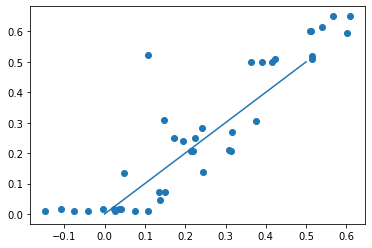

In [62]:
plt.scatter(svm_preds, y_test)

x_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
y_l = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.plot(x_l, y_l)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


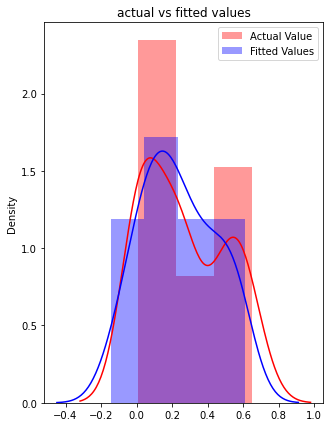

In [63]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist=True, color="r", label="Actual Value")
sns.distplot(svm_preds, hist=True, color="b", label="Fitted Values" , ax=ax)
ax.legend()


plt.title('actual vs fitted values')


plt.show()
plt.close()

In [123]:
df_preds=pd.DataFrame({'Actual':y_test, 'Predicted':svm_preds})
df_preds

,Actual,Predicted
0,0.500000,0.364032
1,0.508000,0.515553
2,0.071000,0.150907
3,0.015000,0.023392
4,0.268695,0.316459
5,0.047000,0.138127
6,0.010000,-0.041159
7,0.508000,0.422903
8,0.600000,0.511311
9,0.600000,0.510295


In [ ]:
######### SVR - 2ND TEST ########

In [60]:
regressor = SVR(kernel='rbf')
regressor.fit(X_tr_sc,y_train)

SVR()

### Prediction of new values

#### Scale the dataframe containing the values to be predicted

In [54]:
# Delete the Fe3_Fe_tot column (all ND values)
no_Fe_ratio.drop(columns="Fe3_Fe_tot", inplace=True)

sp_names_regr = no_Fe_ratio.pop('sptr_name')

# 'Features' matrix for the "regression" dataset
X_regr = no_Fe_ratio.to_numpy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [55]:
sp_names_regr

57     MARS_ALK1300
58     MARS_ALK1400
59     MARS_ALK1500
70                S
72               B2
75               B4
101          MST-25
102         MST-25b
103         MST-25c
104          MST-16
105          MST-26
106          MST-19
107          MST-13
108          MST-28
109         c1mm76a
110           MST-1
111       InterH80a
112       InterH80b
113          MST-14
114          MST-12
115      MST-16_ox1
116      MST-16_ox3
117      MST-16_ox7
118      MST-19_ox1
119      MST-19_ox3
120      MST-19_ox7
121      MST-13_ox1
122      MST-13_ox7
Name: sptr_name, dtype: object

In [43]:
no_Fe_ratio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 57 to 122
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GS_um        28 non-null     float64
 1   std_dev_GS   28 non-null     float64
 2   SiO2         28 non-null     float64
 3   TiO2         28 non-null     float64
 4   Al2O3        28 non-null     float64
 5   Cr2O3        28 non-null     float64
 6   FeO          28 non-null     float64
 7   MnO          28 non-null     float64
 8   MgO          28 non-null     float64
 9   CaO          28 non-null     float64
 10  Na2O         28 non-null     float64
 11  K2O          28 non-null     float64
 12  P2O5         28 non-null     float64
 13  LOI          28 non-null     float64
 14  FeO+TiO2     28 non-null     float64
 15  sl_400_2200  28 non-null     float64
 16  avrg_refl    28 non-null     float64
 17  R415_R750    28 non-null     float64
 18  bin_1        28 non-null     float64
 19  bin_2   

In [56]:
# Regress the values of Fe3+/Fe_TOT using the gradient boosting model
regressed_Fe_rat = reg.predict(no_Fe_ratio)

In [57]:
regressed_Fe_rat

array([0.31573509, 0.59225387, 0.52458465, 0.64049237, 0.6680218 ,
       0.47439138, 0.35244055, 0.4462721 , 0.49518523, 0.35595125,
       0.34663333, 0.34382604, 0.29633585, 0.39541828, 0.26437568,
       0.33063396, 0.29911223, 0.25450909, 0.33459495, 0.32966175,
       0.29597483, 0.29679614, 0.29613629, 0.29957748, 0.29864305,
       0.29793056, 0.29476879, 0.31527157])

In [58]:
no_Fe_ratio

,GS_um,std_dev_GS,SiO2,TiO2,Al2O3,Cr2O3,FeO,MnO,MgO,CaO,...,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,SiAl,CaAl,Sl_500_1000
57,26.5,37.476659,51.84,0.91,16.01,0.4,11.67,0.17,3.61,6.76,...,0.241595,0.243573,0.245658,0.248048,0.251821,0.254286,0.256598,67.85,22.77,1.578073e-04
58,26.5,37.476659,51.84,0.91,16.01,0.4,11.67,0.17,3.61,6.76,...,0.314115,0.319505,0.325062,0.331385,0.338781,0.344522,0.349932,67.85,22.77,1.854672e-04
59,26.5,37.476659,51.84,0.91,16.01,0.4,11.67,0.17,3.61,6.76,...,0.377247,0.385463,0.394777,0.404687,0.415898,0.424115,0.431016,67.85,22.77,2.106655e-04
70,18.0,25.455844,54.23,0.69,16.02,0.0,7.94,0.17,4.13,7.68,...,0.694521,0.702651,0.710119,0.717657,0.723041,0.732300,0.735931,70.25,23.70,4.063802e-04
72,18.0,25.455844,67.49,0.88,13.71,0.0,5.60,0.08,1.70,3.42,...,0.574602,0.584106,0.592217,0.600116,0.606894,0.616291,0.621229,81.20,17.13,3.316500e-04
75,18.0,25.455844,62.68,1.11,14.26,0.0,7.23,0.10,3.19,5.26,...,0.508069,0.517491,0.527642,0.537812,0.545733,0.556155,0.565291,76.94,19.52,3.142864e-04
101,287.5,300.520382,51.07,0.99,8.25,0.0,19.15,0.44,7.21,10.03,...,0.041672,0.042897,0.044587,0.046330,0.048429,0.050908,0.053081,59.32,18.28,4.800000e-07
102,162.5,123.743687,51.07,0.99,8.25,0.0,19.15,0.44,7.21,10.03,...,0.047531,0.049243,0.051574,0.054166,0.057286,0.060599,0.063918,59.32,18.28,2.920000e-06
103,37.5,53.033009,51.07,0.99,8.25,0.0,19.15,0.44,7.21,10.03,...,0.172101,0.179601,0.188680,0.198957,0.209416,0.219672,0.228749,59.32,18.28,6.222000e-05
104,287.5,300.520382,50.66,1.50,8.08,0.0,19.99,0.64,7.18,8.76,...,0.034387,0.034689,0.035589,0.036690,0.038245,0.040398,0.042792,58.74,16.84,-8.840000e-06


In [43]:
sp_names_regr

57     MARS_ALK1300
58     MARS_ALK1400
59     MARS_ALK1500
70                S
72               B2
75               B4
101          MST-25
102         MST-25b
103         MST-25c
104          MST-16
105          MST-26
106          MST-19
107          MST-13
108          MST-28
109         c1mm76a
110           MST-1
111       InterH80a
112       InterH80b
113          MST-14
114          MST-12
115      MST-16_ox1
116      MST-16_ox3
117      MST-16_ox7
118      MST-19_ox1
119      MST-19_ox3
120      MST-19_ox7
121      MST-13_ox1
122      MST-13_ox7
Name: sptr_name, dtype: object

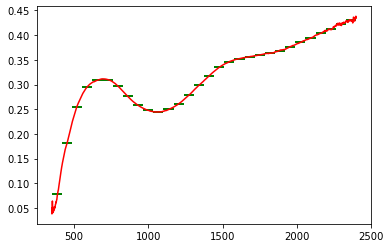

In [60]:
# To use this function the module stats has to be imported
def bin_df(df, bins):
    x_wl = df.iloc[:, 0]
    df_n = df.iloc[:, 1]
    bin_means, bin_edges, binnumber = stats.binned_statistic(x_wl, df_n, bins=bins)
    return bin_means, bin_edges, binnumber
    
    
a = bin_df(df, 30)
# plt.plot(x, yhat, 'r-', label='smoothed_refl')
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
#            label='binned_refl')

x = df.iloc[:, 0]
y = df.iloc[:, 1]


plt.plot(x, y, 'r-', label='spectrum')
plt.hlines(a[0], a[1][:-1], a[1][1:], colors='g', lw=2,
            label='binned_refl')